In [1]:
from torchvision.models import resnet18
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from tqdm import tqdm
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from tqdm import tqdm 
import time
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision.models.resnet import ResNet18_Weights
import pickle
import random
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
import statistics
import matplotlib.pyplot as plt


seed = 42
torch.manual_seed(seed)

In [2]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda:5" # change the available gpu number
else:
    device = "cpu"

In [3]:
subset_fraction = 0.1
num_runs = 1
split_ratio = 0.9
epochs = 200
model_name = "resnet18"
submod_func = "facility-location"

In [4]:
print(device)

cuda:5


### Load Resent Model 

In [5]:
def get_resent18_model(num_classes=10):
    model = torchvision.models.resnet18(weights=None)  # Use 'weights' for pretrained models
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

def get_resent101_model(num_classes=10):
    model = torchvision.models.resnet101(weights=None)  # Use 'weights' for pretrained models
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

In [6]:
# model = get_resent101_model()
# print(type(model))

In [7]:
# # Freeze pre-trained layers
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze some layers for fine-tuning
# for param in model.layer4.parameters():
#     param.requires_grad = True

In [6]:
# Define data transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [7]:
# Load CIFAR10 datasets
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
print(train_dataset[0][0].shape)

torch.Size([3, 32, 32])


## LeNet Model Definition

In [8]:
class LeNet(nn.Module):    
    def __init__(self, out_classes=10):
        super(LeNet, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(400,120),  #in_features = 16 x5x5 
            nn.ReLU(),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84, out_classes),
            # nn.Softmax(dim=1)
        )
        
    def forward(self,x): 
        a1=self.feature_extractor(x)
        # print(a1.shape)
        a1 = torch.flatten(a1,1)
        a2=self.classifier(a1)
        return a2

In [12]:
try:
    with open(f"experiments-{model_name}.pkl", "rb") as f:
        f.seek(0)  # Rewind to the start of the fil
        experiments = pickle.load(f)
except:
    print("no previous data found!")
    experiments = {}

no previous data found!


# Baseline Model Training

### Basic Train Loop

In [13]:
seed = 42
torch.manual_seed(seed)

time_per_run = []
acc_per_run = []

for i in range(num_runs):
    # Define the Model
    if model_name=="LeNeT":
        model = LeNet()
    elif model_name=="resent18":
        model = get_resent18_model()
    elif  model_name=="resnet101":
        model = get_resent101_model()
    
    model = model.to(device)

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()

    # Train the model
    model.train()
    start_time = time.time()
    for epoch in tqdm(range(epochs)):
        # Train loop
        for images, labels in train_dataloader:

            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            # Backward pass and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
    time_taken = time.time() - start_time   
    time_per_run.append(time_taken)  
    print("--- %s seconds ---" % (time_taken))

    # Evaluate on test set
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    acc_per_run.append(accuracy)
    
    print(f"Accuracy: {accuracy:.4f}")
    experiments["base_accuracy"] = accuracy
    experiments["base_time"] = time_taken   
    # print(f"Epoch: [{epoch+1}/{epochs}], Accuracy: {accuracy:.4f}")


if num_runs>1:
    acc_mean = statistics.mean(acc_per_run)
    acc_std = statistics.stdev(acc_per_run)

    time_mean = statistics.mean(time_per_run)
    time_std = statistics.stdev(time_per_run)

    print(f"mean accuracy:{acc_mean}, std accuracy:{acc_std}")
    print(f"mean accuracy:{time_mean}, std accuracy:{time_std}")

    experiments["base_accuracy"] = acc_mean
    experiments["base_acc_std"] = acc_std
    experiments["base_time"] = time_mean
    experiments["base_time_std"] = time_std

with open(f"expermients-{model_name}.pkl", "wb") as f:
    pickle.dump(experiments, f)
    f.close()


100%|██████████| 20/20 [12:15<00:00, 36.79s/it]


--- 735.8969542980194 seconds ---


100%|██████████| 157/157 [00:02<00:00, 59.20it/s]

Accuracy: 0.6680


# Reweight Model Training

In [9]:
# Load CIFAR10 datasets
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

n_samples = len(test_dataset)
n_test = int(n_samples * split_ratio)
n_val = n_samples - n_test
test_dataset, val_dataset = random_split(test_dataset, [n_test, n_val])


# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### Random Sampler for Sampling Validation Data

In [15]:
class RandomSubsetSampler(torch.utils.data.Sampler):
    def __init__(self, dataset, subset_size):
        self.dataset = dataset
        self.subset_size = subset_size

    def __iter__(self):
        indices = random.sample(range(len(self.dataset)), self.subset_size)
        return iter(indices)

    def __len__(self):
        return self.subset_size

subset_sampler = RandomSubsetSampler(val_dataset, 64)
subset_dataloader = DataLoader(val_dataset, sampler=subset_sampler)

### Meta Baseline Trainloop

In [20]:
seed = 42
torch.manual_seed(seed)

time_per_run = []
acc_per_run = []

for i in range(num_runs):
    # Define the Model
    if model_name=="LeNeT":
        model = LeNet()
    elif model_name=="resnet18":
        model = get_resent18_model()
    elif  model_name=="resnet101":
        model = get_resent101_model()

    model = model.to(device)

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    loss_fn_meta = nn.CrossEntropyLoss(reduction='none')

    # Train the model
    model.train()
    start_time = time.time()
    for epoch in tqdm(range(epochs)):
        # Train loop
        for images, labels in train_dataloader:
            
            images = images.to(device)
            labels = labels.to(device)

            if model_name=="LeNeT":
                meta_net = LeNet()
            elif model_name=="resent18":
                meta_net = get_resent18_model()
            elif  model_name=="resnet101":
                meta_net = get_resent101_model()
            
            meta_net.load_state_dict(model.state_dict())
            meta_net = meta_net.to(device)

            optimizer_meta = torch.optim.Adam(meta_net.parameters())

            meta_net.train()
            
            y_f_hat = meta_net(images)
            cost = loss_fn_meta(y_f_hat, labels)
            eps = torch.zeros(cost.size(), requires_grad=True).to(device)
            l_f_meta = torch.sum(cost*eps)

            # meta_net.zero_grad()
            optimizer_meta.zero_grad()
            eps.retain_grad()
            l_f_meta.backward()
            optimizer_meta.step()

            meta_net.eval()

            # grads = torch.autograd.grad(l_f_meta, (meta_net.parameters()), create_graph=True)
            # meta_net.update_params(lr, source_params=grads)
            
            val_images, val_labels = next(iter(subset_dataloader))
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            y_g_hat = meta_net(val_images)
            l_g_meta = loss_fn(y_g_hat, val_labels)

            # grad_eps = torch.autograd.grad(l_g_meta, eps, only_inputs=True)[0]
            # grad_eps = torch.autograd.grad(l_g_meta, eps, only_inputs=True, allow_unused=True)[0]
            # print(grad_eps)

            with torch.no_grad():
                optimizer_meta.zero_grad()
                l_g_meta.backward()
                grad_eps = eps.grad
            
            # print(grad_eps)
            w_tilde = torch.clamp(grad_eps,min=0)
            # w_tilde = torch.clamp(-grad_eps,min=0)
            norm_c = torch.sum(w_tilde)

            if norm_c != 0:
                w = w_tilde / norm_c
            else:
                w = w_tilde
            
            # print(w)
            # break
            # Forward Pass
            outputs = model(images)
            loss = loss_fn_meta(outputs, labels)
            loss = torch.sum(loss*w)
            
            # Backward pass and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    time_taken = time.time() - start_time   
    time_per_run.append(time_taken)  
    experiments["meta_base_time"] = time_taken
    print("--- %s seconds ---" % (time_taken))

    # Evaluate on test set
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    acc_per_run.append(accuracy)
    experiments["meta_base_accuracy"] = accuracy
    print(f"Accuracy: {accuracy:.4f}")

if num_runs>1:
    acc_mean = statistics.mean(acc_per_run)
    acc_std = statistics.stdev(acc_per_run)

    time_mean = statistics.mean(time_per_run)
    time_std = statistics.stdev(time_per_run)

    print(f"mean accuracy:{acc_mean}, std accuracy:{acc_std}")
    print(f"mean accuracy:{time_mean}, std accuracy:{time_std}")

    experiments["meta_base_accuracy"] = acc_mean
    experiments["meta_base_acc_std"] = acc_std
    experiments["meta_base_time"] = time_mean
    experiments["meta_base_time_std"] = time_std   


with open(f"expermients-{model_name}.pkl", "wb") as f:
    pickle.dump(experiments, f)
    f.close()

  0%|          | 0/20 [00:00<?, ?it/s]


NameError: name 'train_dataloader' is not defined

## Milo Setup

### Load Data

In [10]:
# Load CIFAR10 datasets
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
submod_func = "facility-location"
metric = "euclidean"

In [12]:
num_classes = 10
class_data = []
subset_fraction = 0.3
for i in range(num_classes):
    with open(f"milo-base/cifar10/SGE-{metric}/{submod_func}/class-data-{subset_fraction}/class_{i}.pkl", "rb") as f:
        S = pickle.load(f)
        class_data.append(S)

In [13]:
num_sets = len(class_data[0])
data = []
for i in range(num_sets):
    S = []
    for j in range(num_classes):
        S.extend(class_data[j][i])
    data.append(S)

In [14]:
print(len(data[0]))

15000


### Define Dataloader

In [15]:
class SubDataset(Dataset):
    def __init__(self, indices, dataset):
        self.indices = indices
        self.dataset = dataset

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        data_point = self.dataset[index]
        return data_point

## Milo Training Loop

In [ ]:
print(device)

cuda:5


In [ ]:
time_per_run = []
acc_per_run = []

torch.manual_seed(42)

R = 1
for i in range(num_runs):
    # Define Model
    if model_name=="LeNeT":
        model = LeNet()
    elif model_name=="resnet18":
        model = get_resent18_model()
    elif  model_name=="resnet101":
        model = get_resent101_model()
    
    model = model.to(device)

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()

    # Train the model
    model.train()
    start_time = time.time()
    for epoch in tqdm(range(epochs)):
        
        # Train loop
        if epoch%R==0:
            sub_dataset = SubDataset(indices=data[epoch//R], dataset=train_dataset)
            subset_train_dataloader = DataLoader(sub_dataset, batch_size=64, shuffle=True)
            
        for images, labels in subset_train_dataloader:

            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            # Backward pass and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    time_taken = time.time() - start_time   
    time_per_run.append(time_taken)  
    experiments["milo_time"] = time_taken
    print("--- %s seconds ---" % (time_taken))

    # Evaluate on test set
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    acc_per_run.append(accuracy)
    experiments["milo_base_accuracy"] = accuracy
    print(f"Accuracy: {accuracy:.4f}")

if num_runs>1:
    acc_mean = statistics.mean(acc_per_run)
    acc_std = statistics.stdev(acc_per_run)

    time_mean = statistics.mean(time_per_run)
    time_std = statistics.stdev(time_per_run)

    print(f"mean accuracy:{acc_mean}, std accuracy:{acc_std}")
    print(f"mean accuracy:{time_mean}, std accuracy:{time_std}")

    experiments["milo_base_accuracy"] = acc_mean
    experiments["milo_base_acc_std"] = acc_std
    experiments["milo_base_time"] = time_mean
    experiments["milo_base_time_std"] = time_std   


with open(f"expermients-{model_name}.pkl", "wb") as f:
    pickle.dump(experiments, f)
    f.close()

## Milo Comparision all functions

2500


100%|██████████| 200/200 [07:13<00:00,  2.17s/it]


--- 433.2807230949402 seconds ---


100%|██████████| 157/157 [00:01<00:00, 112.40it/s]

Accuracy facility-location 0.05: 0.6020


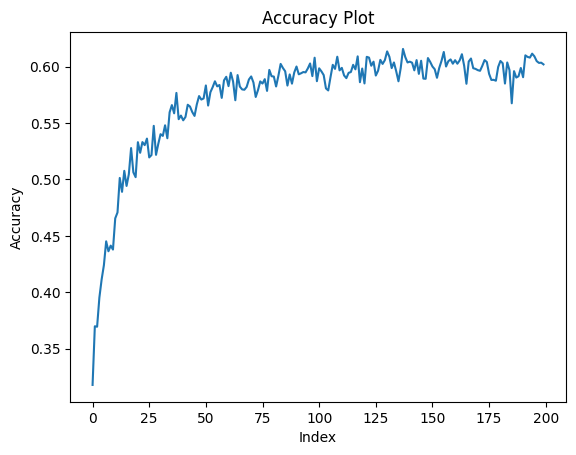

5000


100%|██████████| 200/200 [10:18<00:00,  3.09s/it]


--- 618.0730516910553 seconds ---


100%|██████████| 157/157 [00:01<00:00, 114.50it/s]


Accuracy facility-location 0.1: 0.6895


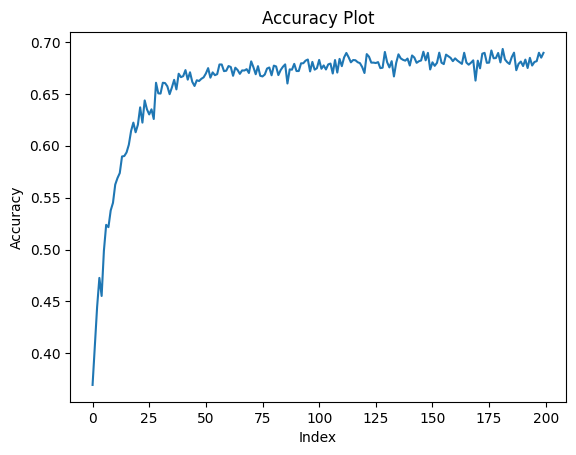

7500


100%|██████████| 200/200 [13:45<00:00,  4.13s/it]


--- 825.8996040821075 seconds ---


100%|██████████| 157/157 [00:01<00:00, 141.79it/s]


Accuracy facility-location 0.15: 0.7178


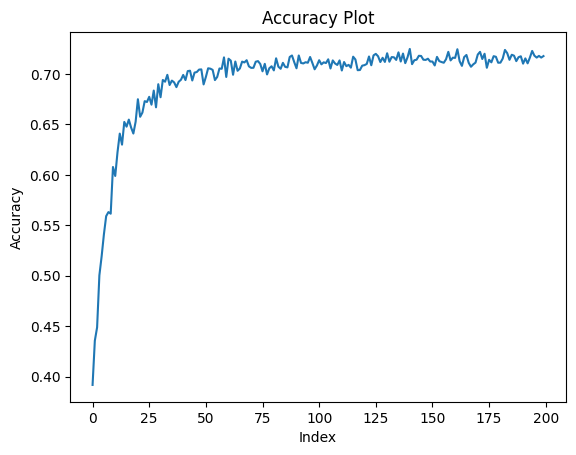

15000


100%|██████████| 200/200 [23:25<00:00,  7.03s/it]


--- 1405.823909521103 seconds ---


100%|██████████| 157/157 [00:01<00:00, 127.24it/s]


Accuracy facility-location 0.3: 0.7602


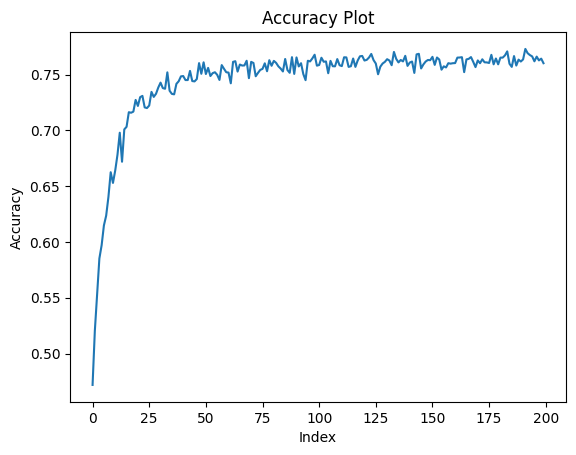

25000


100%|██████████| 200/200 [34:42<00:00, 10.41s/it]


--- 2082.9127209186554 seconds ---


100%|██████████| 157/157 [00:01<00:00, 146.12it/s]


Accuracy facility-location 0.5: 0.7970


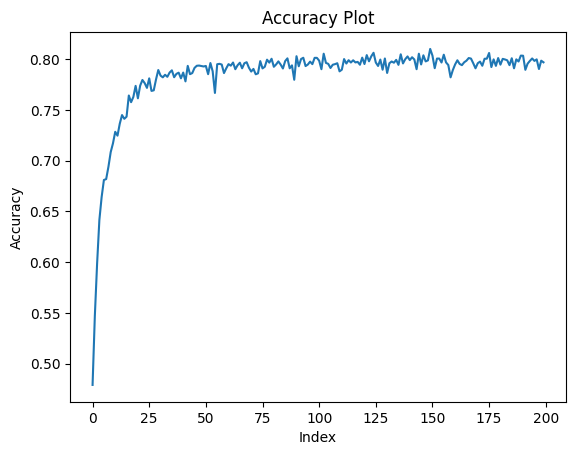

2500


100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


--- 404.18683528900146 seconds ---


100%|██████████| 157/157 [00:01<00:00, 147.63it/s]


Accuracy graph-cut 0.05: 0.5970


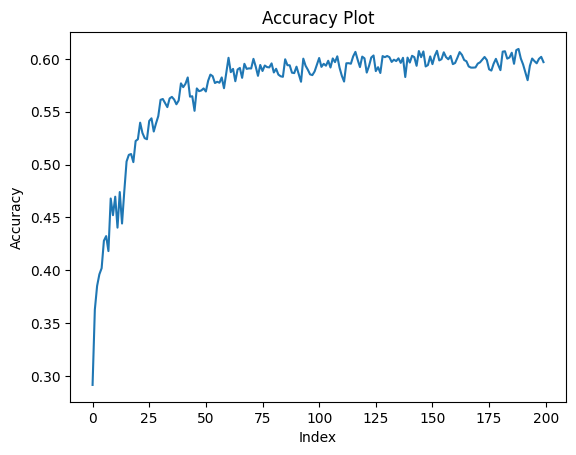

5000


100%|██████████| 200/200 [09:56<00:00,  2.98s/it]


--- 596.8904340267181 seconds ---


100%|██████████| 157/157 [00:01<00:00, 144.41it/s]


Accuracy graph-cut 0.1: 0.6786


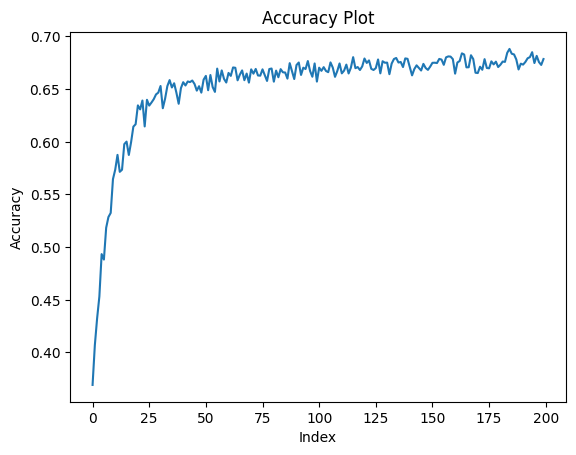

7500


100%|██████████| 200/200 [13:07<00:00,  3.94s/it]


--- 787.9264039993286 seconds ---


100%|██████████| 157/157 [00:01<00:00, 145.84it/s]


Accuracy graph-cut 0.15: 0.7043


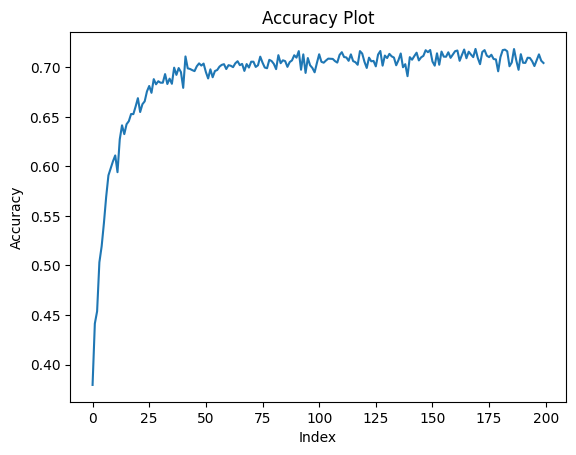

15000


100%|██████████| 200/200 [22:22<00:00,  6.71s/it]


--- 1342.2989962100983 seconds ---


100%|██████████| 157/157 [00:01<00:00, 118.30it/s]


Accuracy graph-cut 0.3: 0.7667


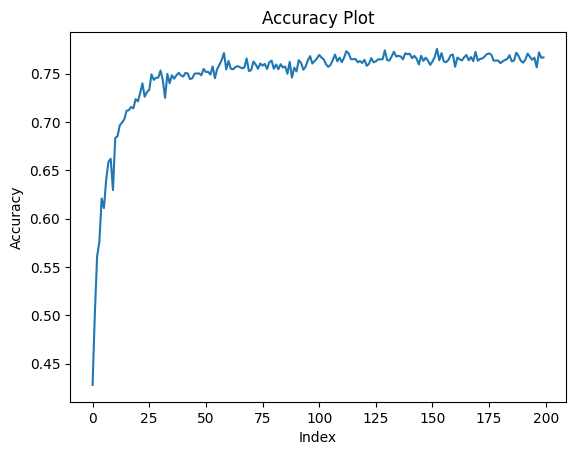

25000


100%|██████████| 200/200 [35:44<00:00, 10.72s/it]


--- 2144.9618475437164 seconds ---


100%|██████████| 157/157 [00:01<00:00, 128.50it/s]


Accuracy graph-cut 0.5: 0.8063


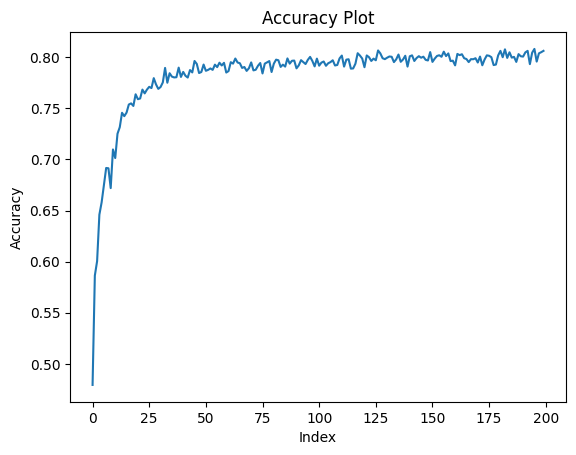

2500


100%|██████████| 200/200 [07:54<00:00,  2.37s/it]


--- 474.5884144306183 seconds ---


100%|██████████| 157/157 [00:01<00:00, 107.44it/s]

Accuracy disparity-min 0.05: 0.6074


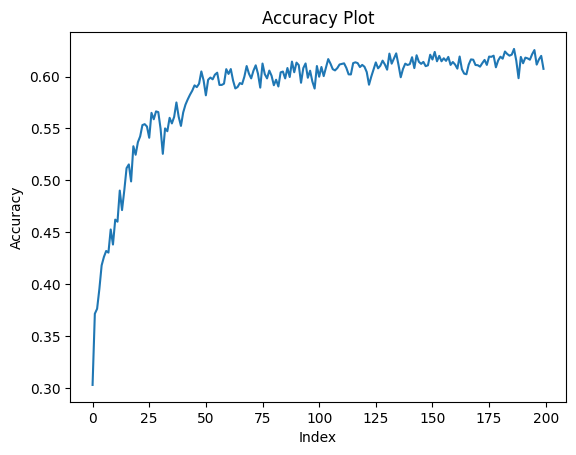

5000


100%|██████████| 200/200 [12:02<00:00,  3.61s/it]


--- 722.5629806518555 seconds ---


100%|██████████| 157/157 [00:01<00:00, 135.85it/s]


Accuracy disparity-min 0.1: 0.6732


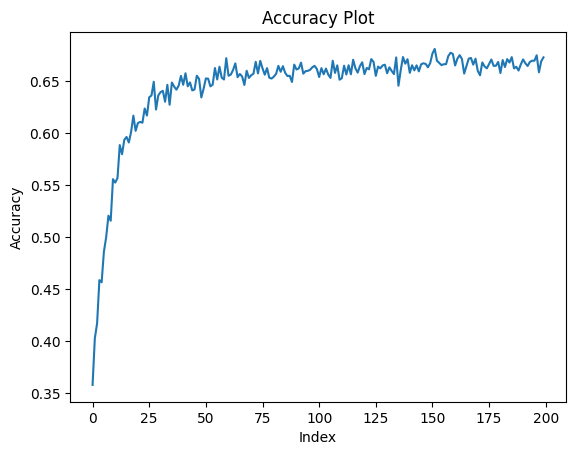

7500


100%|██████████| 200/200 [14:48<00:00,  4.44s/it]


--- 888.0421273708344 seconds ---


100%|██████████| 157/157 [00:01<00:00, 124.21it/s]


Accuracy disparity-min 0.15: 0.7156


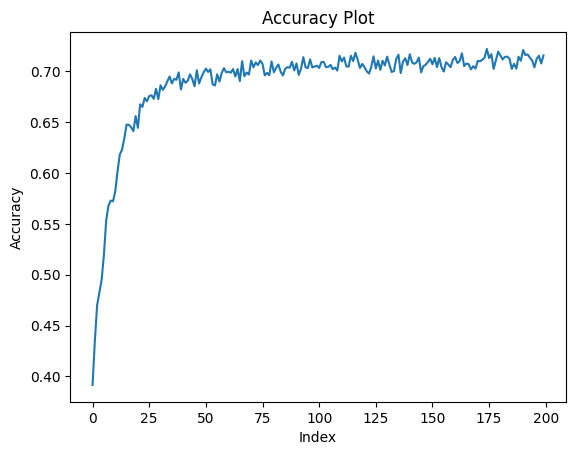

15000


100%|██████████| 200/200 [25:41<00:00,  7.71s/it]


--- 1541.6441173553467 seconds ---


100%|██████████| 157/157 [00:01<00:00, 104.93it/s]

Accuracy disparity-min 0.3: 0.7619


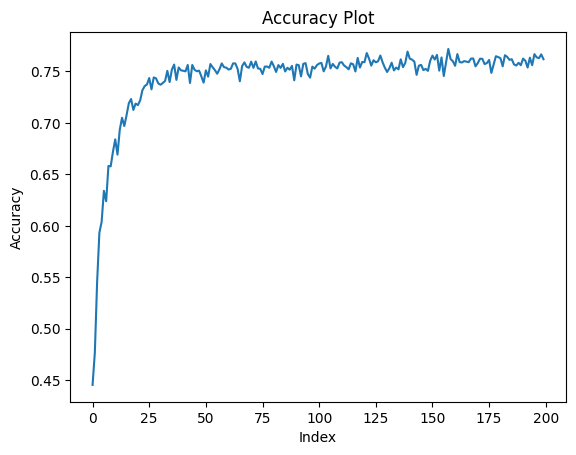

FileNotFoundError: [Errno 2] No such file or directory: './milo-base/cifar10/SGE-euclidean/disparity-min/class-data-0.5/class_3.pkl'

In [19]:
frac_list = [0.05, 0.10, 0.15, 0.3, 0.5]
func_list = ["facility-location", "graph-cut", "disparity-min", "disparity-sum"]
R = 10
epochs = 200
metric = "euclidean"
optimizer_name = "adam"
store = {}

for func in func_list:
    store[func] = {}
    for subset_fraction in frac_list:
        num_classes = 10
        class_data = []
        store[func][subset_fraction] = []
        
        for i in range(num_classes):
                with open(f"./milo-base/cifar10/SGE-{metric}/{func}/class-data-{subset_fraction}/class_{i}.pkl", "rb") as f:
                    S = pickle.load(f)
                    class_data.append(S)
        try:
            pass
        except:
            print("sorry")
            continue

        num_sets = len(class_data[0])
        data = []

        for i in range(num_sets):
            S = []
            for j in range(num_classes):
                S.extend(class_data[j][i])
            data.append(S)
        
        print(len(data[0]))

        torch.manual_seed(42)

        if model_name=="LeNeT":
            model = LeNet()
        elif model_name=="resnet18":
            model = get_resent18_model()
        elif  model_name=="resnet101":
            model = get_resent101_model()
        
        model = model.to(device)

        # Define optimizer and loss function
        if optimizer_name=="SGD_ann":
            optimizer = SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
            lr_scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
        elif optimizer_name=="adam":
            optimizer = torch.optim.Adam(model.parameters())

        loss_fn = nn.CrossEntropyLoss()

        # Train the model
        model.train()
        start_time = time.time()
        for epoch in tqdm(range(epochs)):
            # Train loop
            if epoch%R==0:
                sub_dataset = SubDataset(indices=data[epoch//R], dataset=train_dataset)
                subset_train_dataloader = DataLoader(sub_dataset, batch_size=64, shuffle=True)
                
            for images, labels in subset_train_dataloader:

                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                
                # Backward pass and update weights
                if optimizer_name=="SGD_ann":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()  # Update model weights
                    lr_scheduler.step()     
                elif optimizer_name=="adam":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            
            # Evaluate on test set
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in test_dataloader:
                    images = images.to(device)
                    labels = labels.to(device)

                    outputs = model(images)
                    predictions = torch.argmax(outputs, dim=1)
                    correct += (predictions == labels).sum().item()
                    total += labels.size(0)

            accuracy = correct / total
            store[func][subset_fraction].append(accuracy)

        time_taken = time.time() - start_time    
        print("--- %s seconds ---" % (time_taken))

        # Evaluate on test set
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(test_dataloader):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                predictions = torch.argmax(outputs, dim=1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f"Accuracy {func} {subset_fraction}: {accuracy:.4f}")

        x = range(len(store[func][subset_fraction]))

        # Plot the accuracies
        plt.plot(x, store[func][subset_fraction])

        # Customize the plot (optional)
        plt.xlabel("Index")
        plt.ylabel("Accuracy")
        plt.title("Accuracy Plot")

        # Display the plot
        plt.show()


        with open(f"exps/store-{model_name}-SGD_Cosine_Ann-{epochs}.pkl", "wb") as f:
            pickle.dump(store, f)
            f.close()
        

In [5]:
import pickle
with open(f"store-resnet101.pkl", "rb") as f:
    exp = pickle.load(f)

print(exp["disparity-sum"])

{0.05: 0.4843, 0.1: 0.6158, 0.15: 0.6647}


# META-MILO

In [ ]:
# Load CIFAR10 datasets
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

n_samples = len(test_dataset)
n_test = int(n_samples * split_ratio)
n_val = n_samples - n_test
test_dataset, val_dataset = random_split(test_dataset, [n_test, n_val])


# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
subset_sampler = RandomSubsetSampler(val_dataset, 64)
subset_dataloader = DataLoader(val_dataset, sampler=subset_sampler)

### Meta-Milo Training loop

In [ ]:
time_per_run = []
acc_per_run = []

for i in range(num_runs):
    # Define Model
    if model_name=="LeNeT":
        model = LeNet()
    elif model_name=="resent18":
        model = get_resent18_model()
    elif  model_name=="resnet101":
        model = get_resent101_model()
    
    model = model.to(device)

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    loss_fn_meta = nn.CrossEntropyLoss(reduction='none')

    # Train the model
    model.train()
    start_time = time.time()
    for epoch in tqdm(range(epochs)):
        # Train loop

        if epoch%R==0:
            sub_dataset = SubDataset(indices=data[epoch//R], dataset=train_dataset)
            # train_dataloader = DataLoader(sub_dataset, batch_size=64, shuffle=True, num_workers=2)
            train_dataloader = DataLoader(sub_dataset, batch_size=64, shuffle=True)
        
        for images, labels in train_dataloader:
            
            images = images.to(device)
            labels = labels.to(device)

            # meta_net = get_cifar10_model()
            meta_net = LeNet()
            meta_net.load_state_dict(model.state_dict())

            meta_net = meta_net.to(device)

            optimizer_meta = torch.optim.Adam(meta_net.parameters())

            meta_net.train()
            
            y_f_hat = meta_net(images)
            cost = loss_fn_meta(y_f_hat, labels)
            eps = torch.zeros(cost.size(), requires_grad=True).to(device)
            l_f_meta = torch.sum(cost*eps)

            # meta_net.zero_grad()
            optimizer_meta.zero_grad()
            eps.retain_grad()
            l_f_meta.backward()
            optimizer_meta.step()

            meta_net.eval()

            # grads = torch.autograd.grad(l_f_meta, (meta_net.parameters()), create_graph=True)
            # meta_net.update_params(lr, source_params=grads)
            
            val_images, val_labels = next(iter(subset_dataloader))
            # val_images, val_labels = next(iter(val_dataloader))
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            y_g_hat = meta_net(val_images)
            l_g_meta = loss_fn(y_g_hat, val_labels)

            # grad_eps = torch.autograd.grad(l_g_meta, eps, only_inputs=True)[0]
            # grad_eps = torch.autograd.grad(l_g_meta, eps, only_inputs=True, allow_unused=True)[0]
            # print(grad_eps)

            with torch.no_grad():
                optimizer_meta.zero_grad()
                l_g_meta.backward()
                grad_eps = eps.grad
            
            # print(grad_eps)
            w_tilde = torch.clamp(grad_eps,min=0)
            # w_tilde = torch.clamp(-grad_eps,min=0)
            norm_c = torch.sum(w_tilde)

            if norm_c != 0:
                w = w_tilde / norm_c
            else:
                w = w_tilde
            
            # print(w)
            # break
            # Forward Pass
            outputs = model(images)
            loss = loss_fn_meta(outputs, labels)
            loss = torch.sum(loss*w)
            
            # Backward pass and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    time_taken = time.time() - start_time   
    time_per_run.append(time_taken)  
    experiments["meta_milo_time"] = time_taken   
    
    print("--- %s seconds ---" % (time_taken))

    # Evaluate on test set
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    acc_per_run.append(accuracy) 
    experiments["meta_milo_accuracy"] = accuracy
    print(f"Accuracy: {accuracy:.4f}")

if num_runs>1:
    acc_mean = statistics.mean(acc_per_run)
    acc_std = statistics.stdev(acc_per_run)

    time_mean = statistics.mean(time_per_run)
    time_std = statistics.stdev(time_per_run)

    print(f"mean accuracy:{acc_mean}, std accuracy:{acc_std}")
    print(f"mean accuracy:{time_mean}, std accuracy:{time_std}")

    experiments["meta_milo_base_accuracy"] = acc_mean
    experiments["meta_milo_base_acc_std"] = acc_std
    experiments["meta_milo_base_time"] = time_mean
    experiments["meta_milo_base_time_std"] = time_std   


with open(f"expermients-{model_name}.pkl", "wb") as f:
    pickle.dump(experiments, f)
    f.close()
    

100%|██████████| 20/20 [03:09<00:00,  9.49s/it]


--- 189.7154200077057 seconds ---


100%|██████████| 141/141 [00:01<00:00, 77.99it/s]

Accuracy: 0.5466


## Random Subset

In [ ]:
# Load CIFAR10 datasets
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)


subset_size = int(subset_fraction * len(train_dataset))  # 30% of the full dataset
subset_indices = torch.randperm(len(train_dataset))[:subset_size]  # Randomly select indices
subset_dataset = torch.utils.data.Subset(train_dataset, subset_indices)  # Create the subset


# Create dataloaders
train_dataloader = DataLoader(subset_dataset, batch_size=64, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Random Training Loop

In [ ]:
seed = 42
torch.manual_seed(seed)

time_per_run = []
acc_per_run = []

for i in range(num_runs):
    # Define the Model
    if model_name=="LeNeT":
        model = LeNet()
    elif model_name=="resent18":
        model = get_resent18_model()
    elif  model_name=="resnet101":
        model = get_resent101_model()
    
    model = model.to(device)

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()

    # Train the model
    model.train()
    start_time = time.time()
    for epoch in tqdm(range(epochs)):
        # Train loop
        for images, labels in train_dataloader:

            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            # Backward pass and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    time_taken = time.time() - start_time   
    time_per_run.append(time_taken)  
    experiments["random_time"] = time_taken
    print("--- %s seconds ---" % (time_taken))

    # Evaluate on test set
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    acc_per_run.append(accuracy)
    experiments["random_accuracy"] = accuracy
    print(f"Accuracy: {accuracy:.4f}")
    # print(f"Epoch: [{epoch+1}/{epochs}], Accuracy: {accuracy:.4f}")

if num_runs>1:
    acc_mean = statistics.mean(acc_per_run)
    acc_std = statistics.stdev(acc_per_run)

    time_mean = statistics.mean(time_per_run)
    time_std = statistics.stdev(time_per_run)

    print(f"mean accuracy:{acc_mean}, std accuracy:{acc_std}")
    print(f"mean accuracy:{time_mean}, std accuracy:{time_std}")

    experiments["random_accuracy"] = acc_mean
    experiments["random_acc_std"] = acc_std
    experiments["random_time"] = time_mean
    experiments["ramdom_time_std"] = time_std   


with open(f"expermients-{model_name}.pkl", "wb") as f:
    pickle.dump(experiments, f)
    f.close()

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


--- 48.31951141357422 seconds ---


100%|██████████| 157/157 [00:01<00:00, 138.50it/s]

Accuracy: 0.5630


In [ ]:
print(time_per_run)
print(acc_per_run)

[44.21948027610779]
[]


## Random Subset Meta

In [ ]:
# Load CIFAR10 datasets
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)


subset_size = int(subset_fraction * len(train_dataset))  # 30% of the full dataset
subset_indices = torch.randperm(len(train_dataset))[:subset_size]  # Randomly select indices
subset_dataset = torch.utils.data.Subset(train_dataset, subset_indices)  # Create the subset


# Create dataloaders
train_dataloader = DataLoader(subset_dataset, batch_size=64, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
seed = 42
torch.manual_seed(seed)

for i in range(num_runs):
    # Define the Model
    if model_name=="LeNeT":
        model = LeNet()
    elif model_name=="resent18":
        model = get_resent18_model()
    elif  model_name=="resnet101":
        model = get_resent101_model()
    
    model = model.to(device)

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    loss_fn_meta = nn.CrossEntropyLoss(reduction='none')

    # Train the model
    model.train()
    start_time = time.time()
    for epoch in tqdm(range(epochs)):
        # Train loop
        for images, labels in train_dataloader:
            
            images = images.to(device)
            labels = labels.to(device)

            # meta_net = get_cifar10_model()
            meta_net = LeNet()
            meta_net.load_state_dict(model.state_dict())

            meta_net = meta_net.to(device)

            optimizer_meta = torch.optim.Adam(meta_net.parameters())

            meta_net.train()
            
            y_f_hat = meta_net(images)
            cost = loss_fn_meta(y_f_hat, labels)
            eps = torch.zeros(cost.size(), requires_grad=True).to(device)
            l_f_meta = torch.sum(cost*eps)

            # meta_net.zero_grad()
            optimizer_meta.zero_grad()
            eps.retain_grad()
            l_f_meta.backward()
            optimizer_meta.step()

            meta_net.eval()

            # grads = torch.autograd.grad(l_f_meta, (meta_net.parameters()), create_graph=True)
            # meta_net.update_params(lr, source_params=grads)
            
            val_images, val_labels = next(iter(subset_dataloader))
            # val_images, val_labels = next(iter(val_dataloader))
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            y_g_hat = meta_net(val_images)
            l_g_meta = loss_fn(y_g_hat, val_labels)

            # grad_eps = torch.autograd.grad(l_g_meta, eps, only_inputs=True)[0]
            # grad_eps = torch.autograd.grad(l_g_meta, eps, only_inputs=True, allow_unused=True)[0]
            # print(grad_eps)

            with torch.no_grad():
                optimizer_meta.zero_grad()
                l_g_meta.backward()
                grad_eps = eps.grad
            
            # print(grad_eps)
            w_tilde = torch.clamp(grad_eps,min=0)
            # w_tilde = torch.clamp(-grad_eps,min=0)
            norm_c = torch.sum(w_tilde)

            if norm_c != 0:
                w = w_tilde / norm_c
            else:
                w = w_tilde
            
            # print(w)
            # break
            # Forward Pass
            outputs = model(images)
            loss = loss_fn_meta(outputs, labels)
            loss = torch.sum(loss*w)
            
            # Backward pass and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    
    time_taken = time.time() - start_time   
    time_per_run.append(time_taken)  
    experiments["random_meta_time"] = time_taken
    print("--- %s seconds ---" % (time_taken))

    # Evaluate on test set
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    acc_per_run.append(accuracy)
    experiments["random_meta_accuracy"] = accuracy
    print(f"Accuracy: {accuracy:.4f}")

if num_runs>1:
    acc_mean = statistics.mean(acc_per_run)
    acc_std = statistics.stdev(acc_per_run)

    time_mean = statistics.mean(time_per_run)
    time_std = statistics.stdev(time_per_run)

    print(f"mean accuracy:{acc_mean}, std accuracy:{acc_std}")
    print(f"mean accuracy:{time_mean}, std accuracy:{time_std}")

    experiments["random_meta_accuracy"] = acc_mean
    experiments["random_meta_acc_std"] = acc_std
    experiments["random_meta_time"] = time_mean
    experiments["ramdom_meta_time_std"] = time_std 

with open(f"expermients-{model_name}.pkl", "wb") as f:
    pickle.dump(experiments, f)
    f.close()


100%|██████████| 20/20 [01:55<00:00,  5.77s/it]


--- 115.40682768821716 seconds ---


100%|██████████| 157/157 [00:01<00:00, 151.24it/s]

Accuracy: 0.5454


In [ ]:
import pickle
with open(f"expermients-{model_name}.pkl", "rb") as f:
    experiments = pickle.load(f)

print(experiments)


{'base_accuracy': 0.6497, 'base_time': 172.40934538841248, 'meta_base_time': 353.98308181762695, 'meta_base_accuracy': 0.5588888888888889, 'milo_time': 83.56228446960449, 'meta_milo_time': 189.7154200077057, 'meta_milo_accuracy': 0.5465555555555556, 'random_time': 48.31951141357422, 'random_accuracy': 0.563, 'random_meta_time': 115.40682768821716, 'random_meta_accuracy': 0.5454}
